In [3]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# nicer defaults
plt.rcParams["figure.figsize"] = (8,5)
plt.rcParams["axes.grid"] = False

# load data
titanic = sns.load_dataset("titanic")
# light tidy: cast categories, drop obvisous junk columns if needed
cat_cols = ["sex", "class", "embark_town", "who", "adult_male", "alive", "alone", "deck", "embarked"]
for c in cat_cols:
    if c in titanic.columns:
        titanic[c] = titanic[c].astype("category")

titanic.head()


,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


/var/folders/hd/wvpfmg893d9ff7g872_k6hvh0000gn/T/ipykernel_74073/1999767839.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  survival_by_class = titanic.groupby("class")["survived"].mean().sort_values(ascending=False)


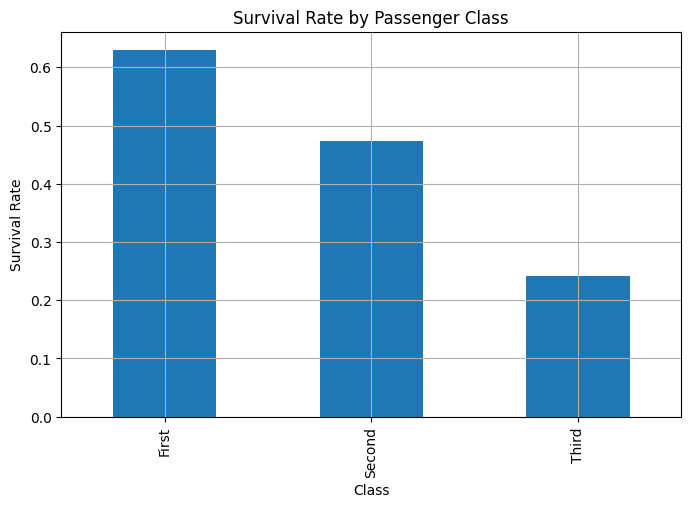

In [4]:
survival_by_class = titanic.groupby("class")["survived"].mean().sort_values(ascending=False)
ax = survival_by_class.plot(kind="bar")
ax.set_title("Survival Rate by Passenger Class")
ax.set_ylabel("Survival Rate")
ax.set_xlabel("Class")
plt.show()

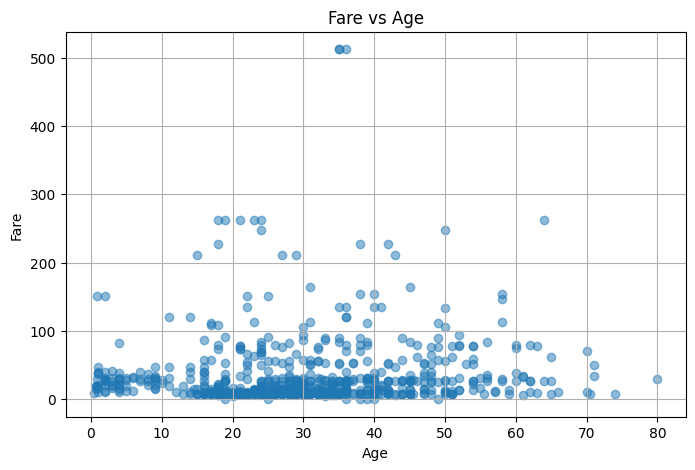

In [11]:
df = titanic.dropna(subset=["age", "fare"])
plt.scatter(df["age"], df["fare"], alpha=0.5)
plt.title("Fare vs Age")
plt.xlabel("Age")
plt.ylabel("Fare")
# plt.ylim(0,600)
plt.show()


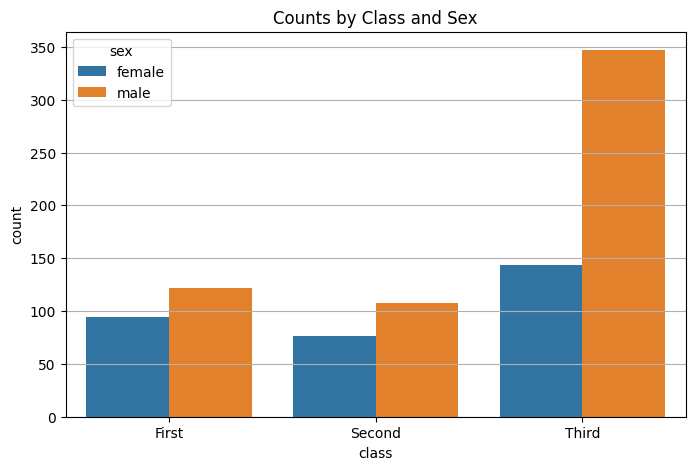

In [14]:
sns.countplot(data=titanic, x="class", hue="sex")
plt.title("Counts by Class and Sex")
plt.show()

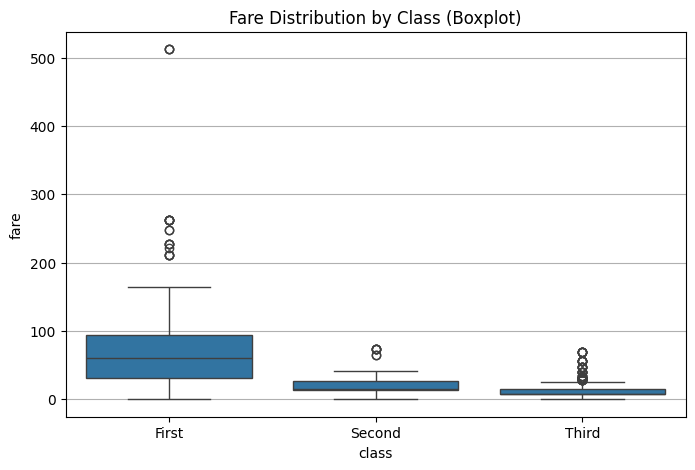

In [ ]:
sns.boxplot(data=titanic, x="class", y="fare")
plt.title("Fare Distribution by Class (Boxplot)")
plt.ylim(0,400)
plt.show()

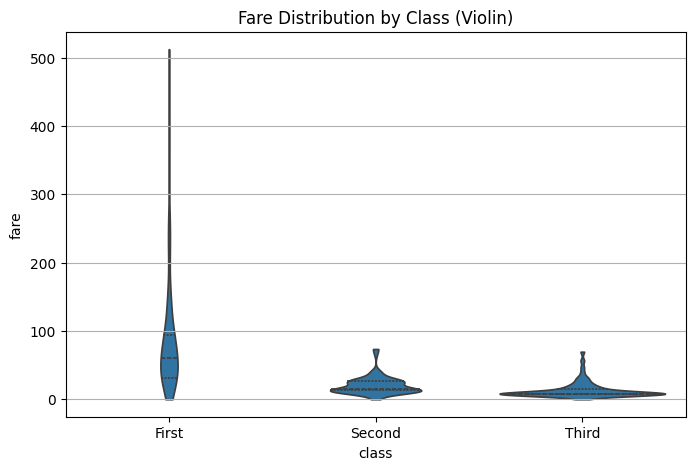

In [ ]:
sns.violinplot(data=titanic, x="class", y="fare", inner="quartile", cut=0)
plt.title("Fare Distribution by Class (Violin)")
plt.ylim(0, 400)
plt.show()

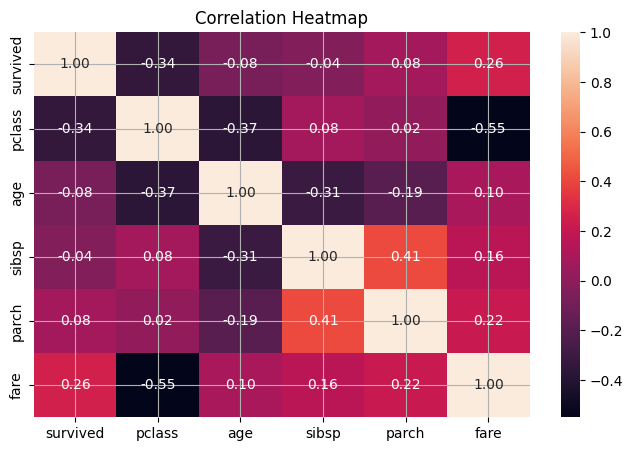

In [17]:
num = titanic.select_dtypes(include=["number"])
sns.heatmap(num.corr(numeric_only=True), annot=True, fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

# So what is each graph good for:

- Countplot: Categorical frequencies
- Boxplot: Summary of distribution (median, spread, outliers)
- Violin plot: Full shape of the distribution (density)
- Heatmap: matrix of correlations between numeric columns

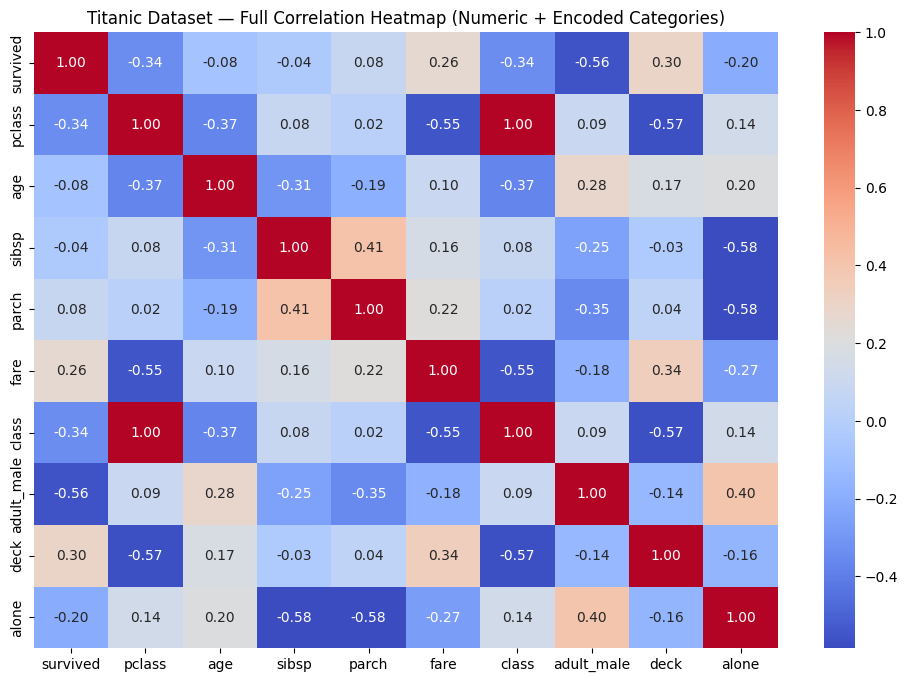

In [22]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# load dataset
titanic = sns.load_dataset("titanic")

# convert categorical columns to codes (0,1,2...)
titanic_encoded = titanic.copy()
for col in titanic_encoded.select_dtypes(include="category").columns:
    titanic_encoded[col] = titanic_encoded[col].cat.codes

corr = titanic_encoded.corr(numeric_only=True)

plt.figure(figsize=(12,8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Titanic Dataset — Full Correlation Heatmap (Numeric + Encoded Categories)")
plt.show()


Task: Compare fare distributions by sex within class using `sns.boxplot` with `hue="sex"`. Limit fares to 0 - 400.
  

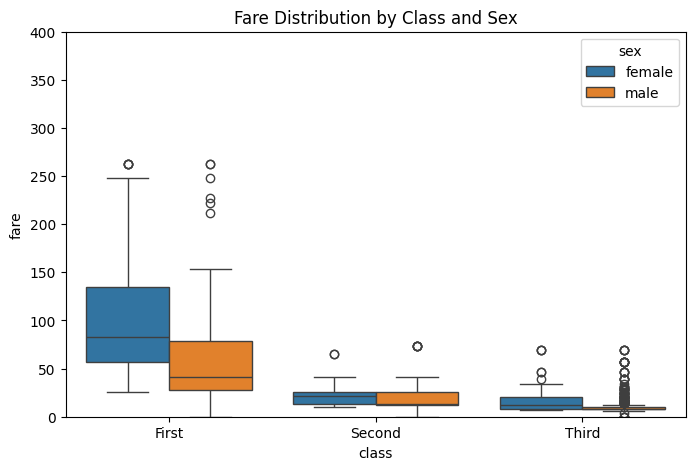

In [4]:
import seaborn as sns

sns.boxplot(data=titanic, x="class", y="fare", hue="sex")
plt.title("Fare Distribution by Class and Sex")
plt.ylim(0, 400)
plt.show()

Use `sns.scatterplot` to plot `age` vs `fare` with `hue="survived"` and `style="sex"`

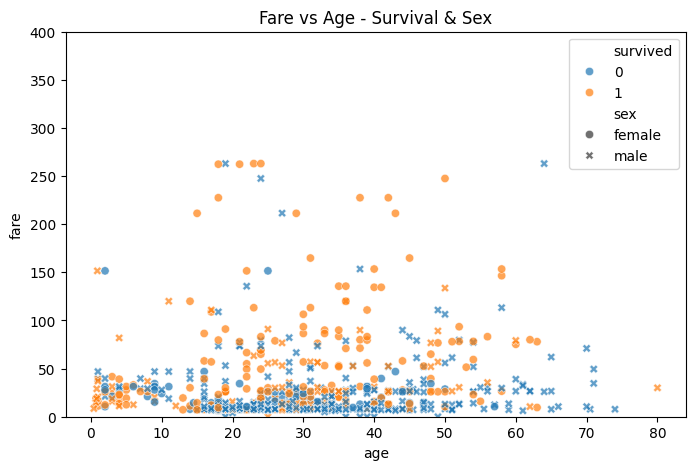

In [5]:
df = titanic.dropna(subset=["age", "fare", "sex", "survived"])
sns.scatterplot(data=df, x="age", y="fare", hue="survived", style="sex", alpha=0.7)
plt.title("Fare vs Age - Survival & Sex")
plt.ylim(0,400)
plt.show()


## Plotly

In [7]:
df = titanic.dropna(subset=["age", "fare", "class", "sex", "embark_town"])
fig = px.scatter(
    df, x="age", y="fare",
    color="class", symbol="sex",
    hover_data=["embark_town", "alone", "who"],
    range_y=[0, 400],
    title="Fare vs Age - Interactive (hover me!)"
)
fig.show()

In [12]:
# this drops rows with missing values, copy avoids Pandas warnings when you add a new column
df = titanic.dropna(subset=["sex","class","survived"]).copy()

# gets the mean group rate (so every row carries its groups survival rate)
df["survival_rate"] = df.groupby(["sex","class"])["survived"].transform("mean")

# collapse to one group per row
agg = df.drop_duplicates(subset=["sex","class"])[["sex","class","survival_rate"]]
# agg.head()
# start with the default slice before we add a dropdown
fig = px.bar(
    agg.query("sex=='male'"),
    x="class", y="survival_rate",
    title="Survival Rate by Class — Filter by Sex"
)

# add dropdown to switch sex
fig.update_layout(
    updatemenus=[{
        "buttons":[
            {"label":"Male","method":"update",
             "args":[{"x":[agg.query('sex==\"male\"')["class"]],
                      "y":[agg.query('sex==\"male\"')["survival_rate"]]},
                     {"title":"Survival Rate by Class — Male"}]},
            {"label":"Female","method":"update",
             "args":[{"x":[agg.query('sex==\"female\"')["class"]],
                      "y":[agg.query('sex==\"female\"')["survival_rate"]]},
                     {"title":"Survival Rate by Class — Female"}]},
        ],
        "direction":"right", "x":0.5, "y":1.2
    }]
)
""" 
updatemenus adds a dropdown.
method:"update" lets you update both trace data and layout.
The first dict in args updates trace properties (x, y).
Plotly expects a list per trace → you have one trace, so you pass lists of length 1.
The second dict in args updates layout (here, the title).
Each button filters agg by sex and swaps the data in the existing trace.
"""

# Survival rate is a proportion, we do this to make the comparaion fair
fig.update_yaxes(range=[0,1], title="Survival Rate")
fig.show()

/var/folders/hd/wvpfmg893d9ff7g872_k6hvh0000gn/T/ipykernel_95455/2425840251.py:5: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



Build an interactive histogram of `age` with:
- color by `sex`
- `nbins=30`
- title + x/y labels
- filter out `age` nulls

https://plotly.com/python/histograms/


In [13]:
# dropping null NaN rows that contain these values
df = titanic.dropna(subset=["age", "sex"])
fig = px.histogram(
    df, x="age", color="sex", nbins=30, barmode="overlay", opacity=0.7,
    title="Age Distribution by Sex"
)
fig.update_layout(xaxis_title="Age", yaxis_title="Count")
fig.show()


### Common Pitfalls & fixes

- Cluttered Legends: merge exocings or use direct lables/annotations.
- Inconsistent scales: align axis when comparing panels; limit or log-scale
- Too many colours: try to use less than six distinct hues
- Forgetting titles/units: ALWAYS remember  to title and give units
- Sampling bias: visuals reflect the data you have, add caveats (or use if influencing descisions). 

### When to use

- *Matplotlib*: maximum control; templates for final static figures
- *Seaborn*: fast, beautiful statistics, great defaults
- *Plotly*: interaction & sharing; great for stakeholder demos and dashboards

So a *general* rule of thumb:
- Explore in Seaborn
- Refine in Matplotlib
- Present interactively in Plotly (if needed).